In [190]:
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
from math import sqrt, log
%matplotlib inline

In [3]:
k = 10
steps = 1000

In [203]:
class KBanditProblem:
    
    def __init__(self, k, stationary=True):
        self.k = k
        self.stationary = stationary
        self.values = np.random.normal(loc=0.0, scale=1, size=k)
        self.optimal = self.values.argmax()
        
    def generate_reward(self, action):
        if not self.stationary:
            self.values += np.random.normal(loc=0.0, scale=0.01, size=self.k)
            self.optimal = self.values.argmax()
        return np.random.normal(loc=self.values[action], scale=1)

In [204]:
class KBanditSolution:
    
    def __init__(self, problem, steps):
        self.problem = problem
        self.steps = steps
        
        self.average_reward = 0
        self.average_rewards = np.array([])
        self.optimal_percentage = 0
        self.optimal_precentages = np.array([])
        
    def count_statistics(self, action, reward, step):
        self.average_reward += (1 / (step + 1)) * (reward - self.average_reward)
        self.optimal_percentage += (1 / (step + 1)) * ((1 if action == self.problem.optimal else 0) - self.optimal_percentage)
        self.average_rewards = np.append(self.average_rewards, self.average_reward)
        self.optimal_precentages = np.append(self.optimal_precentages, self.optimal_percentage)


## E-Greedy Algorithm

In [205]:
class EGreedy(KBanditSolution):
    
    def solve(self, exploration_rate, initial_value):
        Q = {i: initial_value for i in range(k)} # 1. Value function
        N = {i: 0 for i in range(k)} # 2. Number of actions, for update rule

        for i in range(self.steps): # 3. Main loop
            explore = random.uniform(0, 1) < exploration_rate  # 6. Exploration
            if explore:
                action = random.randint(0, k - 1) # 5. Exploration: Choosing random action
            else:
                action = max(Q, key=Q.get) # 6. Choose action with maximum mean reward

            reward = self.problem.generate_reward(action) # 7. Get reward for current action
            N[action] += 1 # 8. Update action number
            Q[action] += (1 / N[action]) * (reward - Q[action]) # 9. Update value dict 
            self.count_statistics(action, reward, i)

In [173]:
def average_data(Solution, test_parameter_name, test_parameter_values, solve_data={}, problems_count=500, stationary=False, steps=1000):
    data = {i: {'avg': np.zeros(steps), 'opt': np.zeros(steps)} for i in test_parameter_values}
    for i in range(problems_count):
        problem = KBanditProblem(k=10, stationary=stationary)
        for d in data.keys():
            solution = Solution(problem, steps)
            local_solve_data = solve_data
            local_solve_data[test_parameter_name] = d
            solution.solve(**local_solve_data)
            
            data[d]['avg'] += (1 / (i + 1)) * (solution.average_rewards - data[d]['avg'])
            data[d]['opt'] += (1 / (i + 1)) * (solution.optimal_precentages - data[d]['opt'])
    return data

In [184]:
def create_plots(data, title, legend_title, steps=1000):
    fig, ax = plt.subplots(1,2, figsize=(20, 5), dpi=300)

    for e in data.keys():
        ax[0].plot(np.array(list(range(steps))), data[e]['opt'], label=str(e))

    ax[0].set_ylabel('% optimal', fontsize=16)
    ax[0].set_xlabel('Step number', fontsize=16)

    for e in data.keys():
        ax[1].plot(np.array(list(range(steps))), data[e]['avg'], label=str(e))

    ax[1].set_ylabel('Average reward', fontsize=16)
    ax[1].set_xlabel('Step number', fontsize=16)

    plt.suptitle(title, fontsize=32)
    plt.legend(title=legend_title, loc=9, bbox_to_anchor=(0.9, -0.2))

    plt.xkcd()

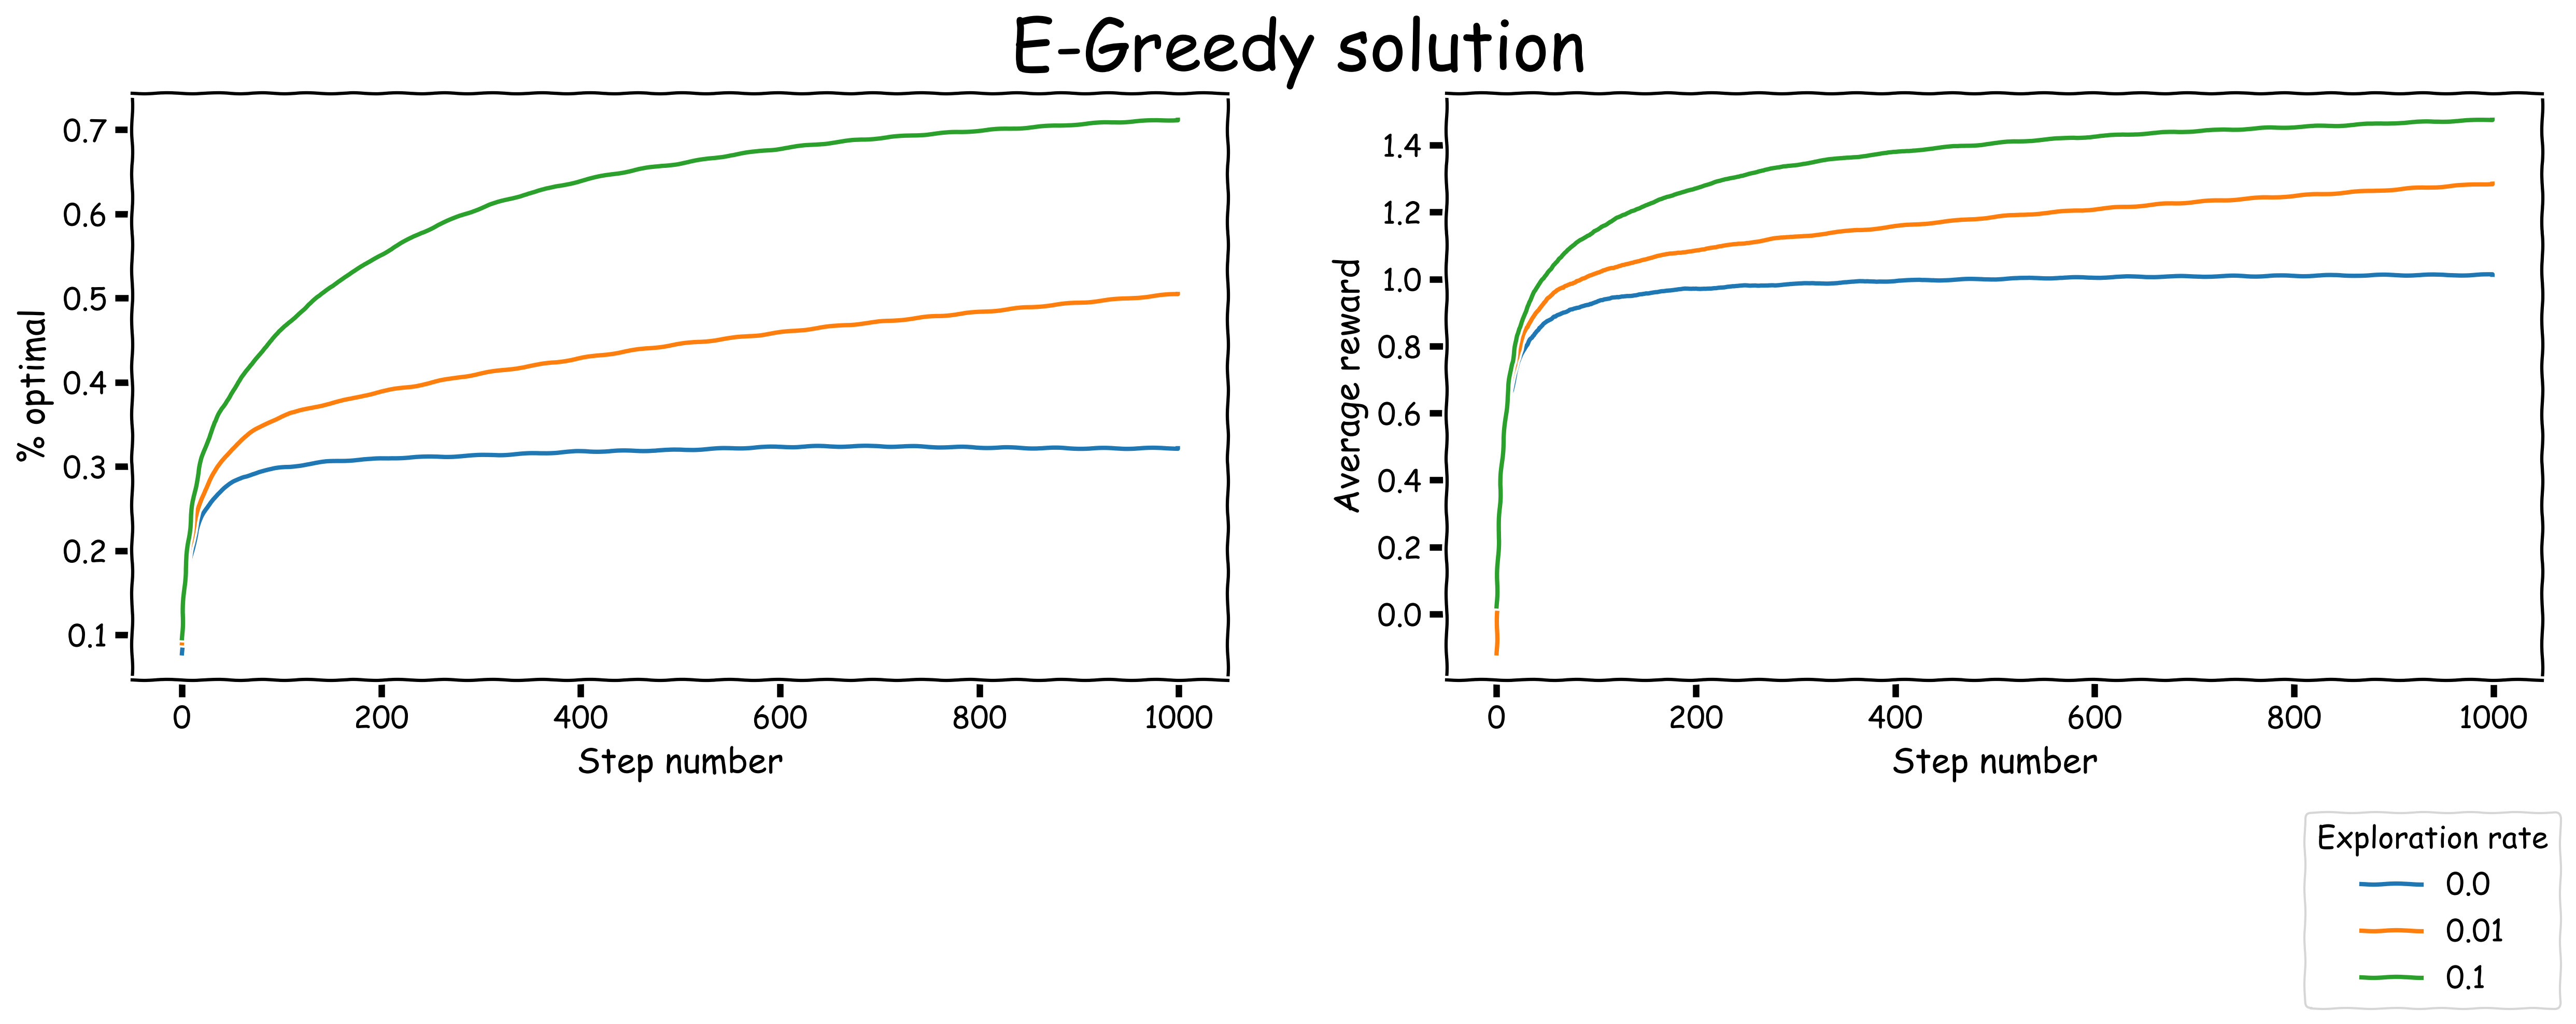

In [206]:
exploration_levels = [0.0, 0.01, 0.1]
data = average_data(EGreedy, 'exploration_rate', exploration_levels, solve_data={'initial_value': 0})
create_plots(data, 'E-Greedy solution', 'Exploration rate')

# Weighted Average Algorithm

In [218]:
class WeightedAverage(KBanditSolution):
    
    def solve(self, exploration_rate, step_size, initial_value):
        Q = {i: initial_value for i in range(k)} # 1. Value function
        N = {i: 0 for i in range(k)} # 2. Number of actions, for update rule

        for i in range(self.steps): # 3. Main loop
            explore = random.uniform(0, 1) < exploration_rate  # 6. Exploration
            if explore:
                action = random.randint(0, k - 1) # 5. Exploration: Choosing random action
            else:
                action = max(Q, key=Q.get) # 6. Choose action with maximum mean reward

            reward = self.problem.generate_reward(action) # 7. Get reward for current action
            N[action] += 1 # 8. Update action number
            Q[action] += step_size * (reward - Q[action]) # 9. Update value dict 
            self.count_statistics(action, reward, i)

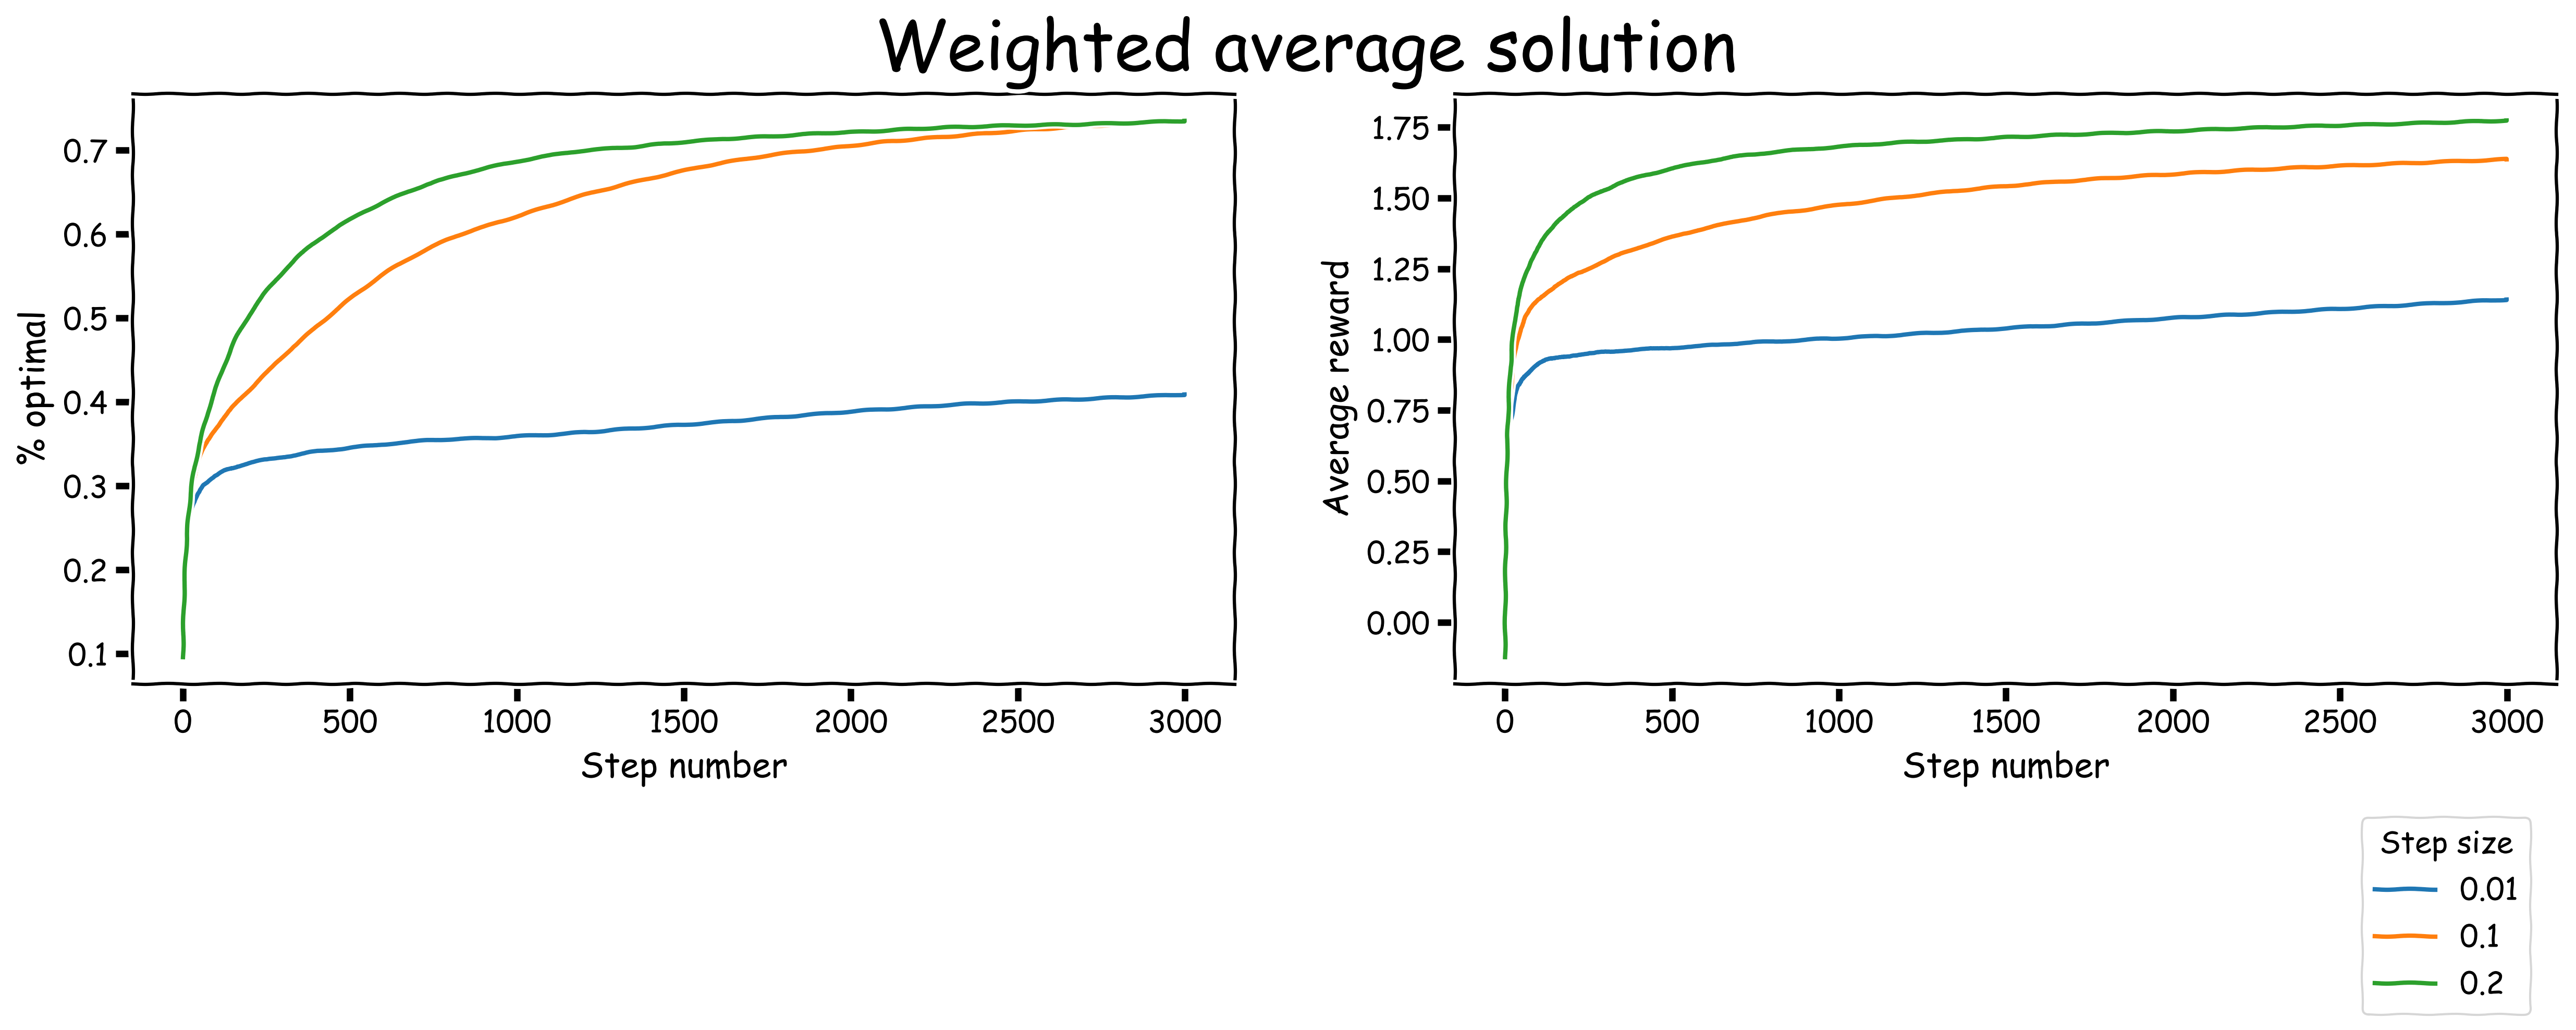

In [220]:
step_sizes = [0.01, 0.1, 0.2]
data = average_data(WeightedAverage, 'step_size', step_sizes, solve_data={'exploration_rate': 0.1, 'initial_value': 0}, steps=3000)
create_plots(data, 'Weighted average solution', 'Step size', steps=3000)

# Optimistic vs Realistic

In [221]:
pessimistic_E_greedy_data = average_data(EGreedy, 'exploration_rate', [0.0], {'initial_value': 0})
optimistic_E_greedy_data = average_data(EGreedy, 'exploration_rate', [0.0], {'initial_value': 5})

pessimistic_exploration_data = average_data(EGreedy, 'exploration_rate', [0.1], {'initial_value': 0})
optimistic_exploration_data = average_data(EGreedy, 'exploration_rate', [0.1], {'initial_value': 5})

pessimistic_weighted_data = average_data(WeightedAverage, 'step_size', [0.1], solve_data={'exploration_rate': 0.1, 'initial_value': 0})
optimistic_weighted_data = average_data(WeightedAverage, 'step_size', [0.1], solve_data={'exploration_rate': 0.1, 'initial_value': 5})

In [222]:
greedy_data = {
    'Realistic [0]': pessimistic_E_greedy_data[0.0],
    'Optimistic [5]': optimistic_E_greedy_data[0.0]
}

exploration_data = {
    'Realistic [0]': pessimistic_exploration_data[0.1],
    'Optimistic [5]': optimistic_exploration_data[0.1]
}
    

weighted_data = {
    'Realistic [0]': pessimistic_weighted_data[0.1],
    'Optimistic [5]': optimistic_weighted_data[0.1]
}

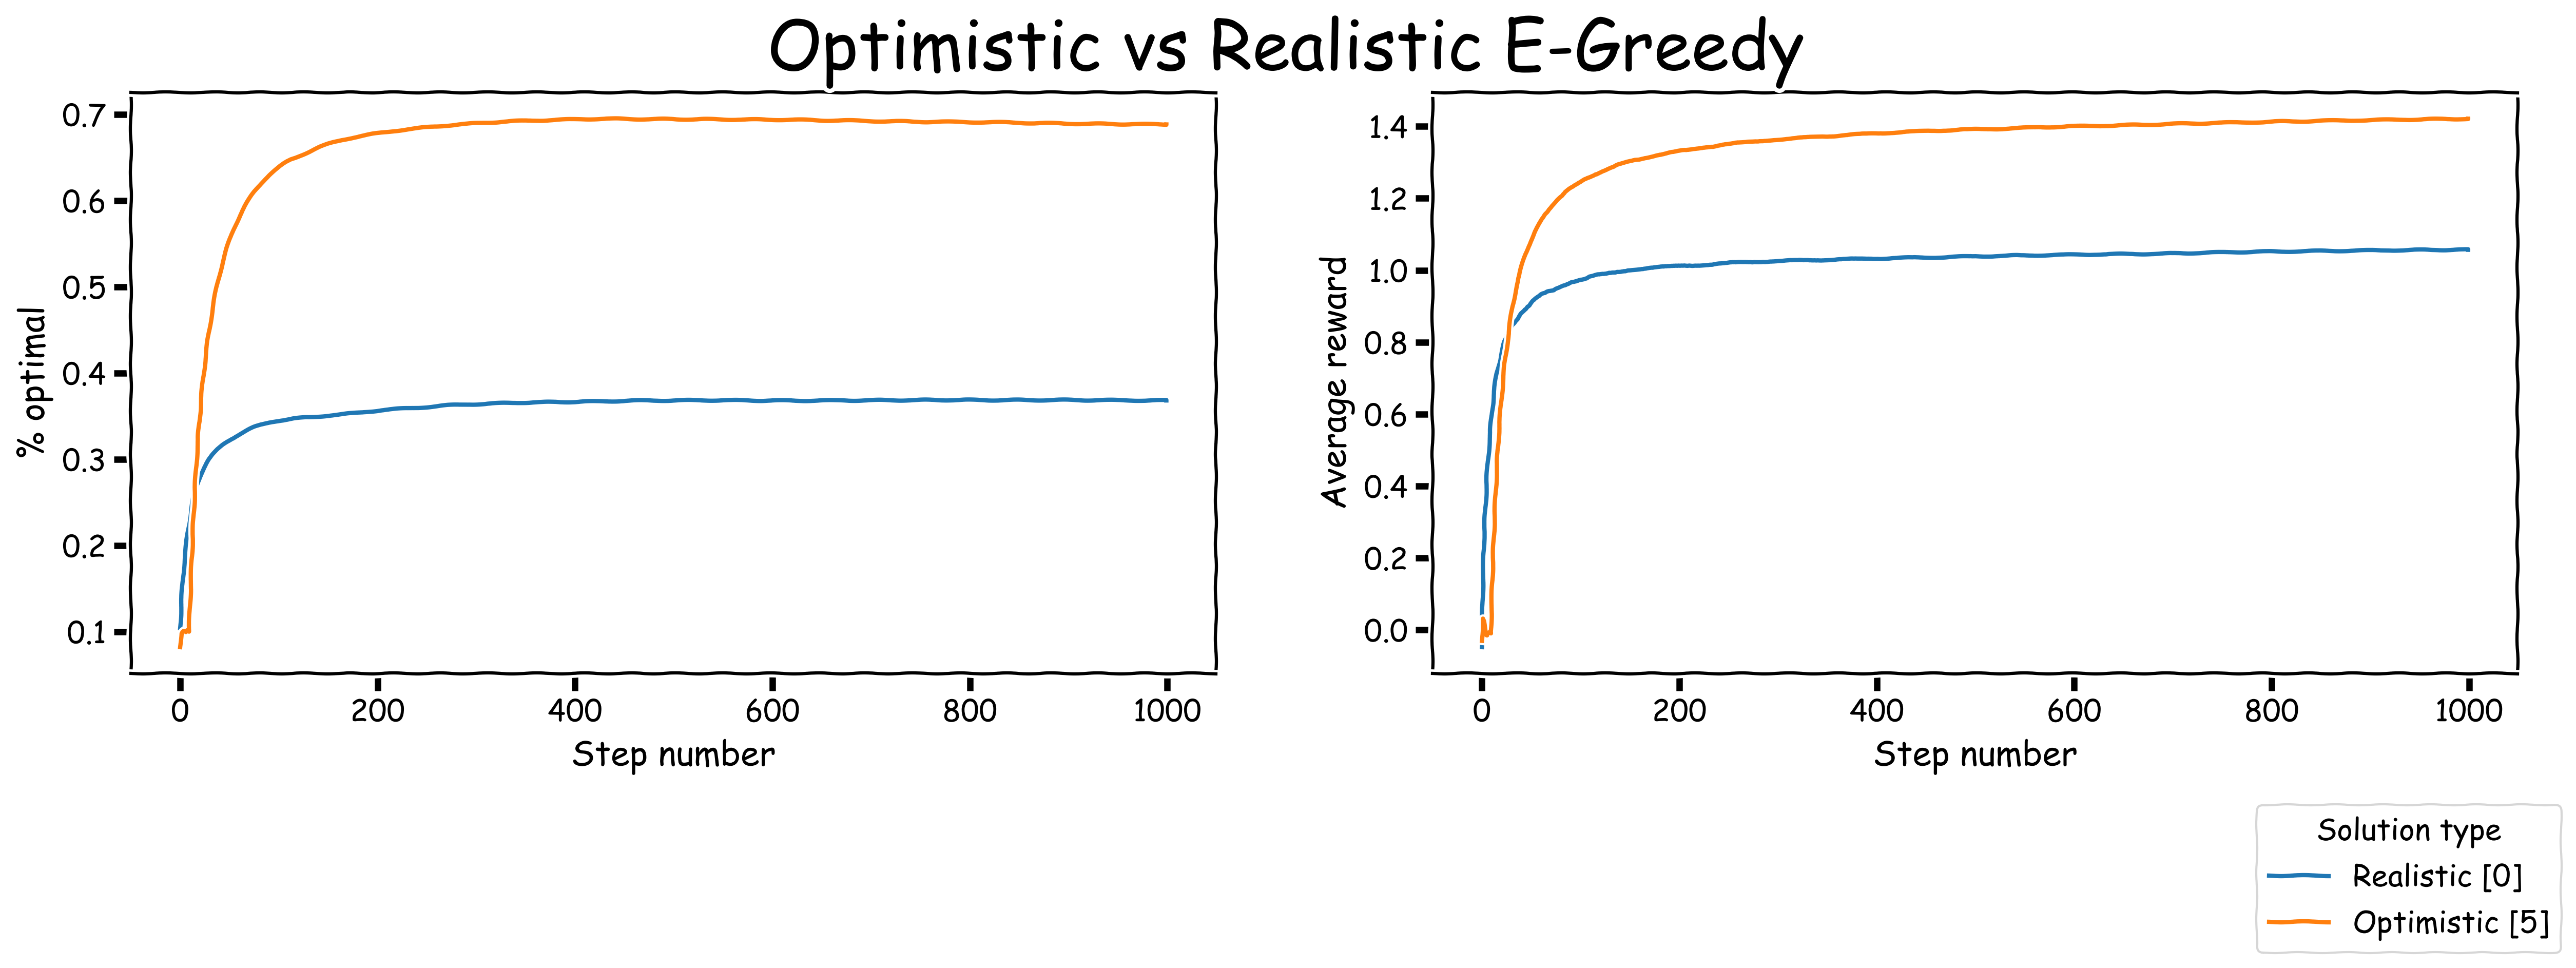

In [223]:
create_plots(greedy_data, 'Optimistic vs Realistic E-Greedy', 'Solution type')

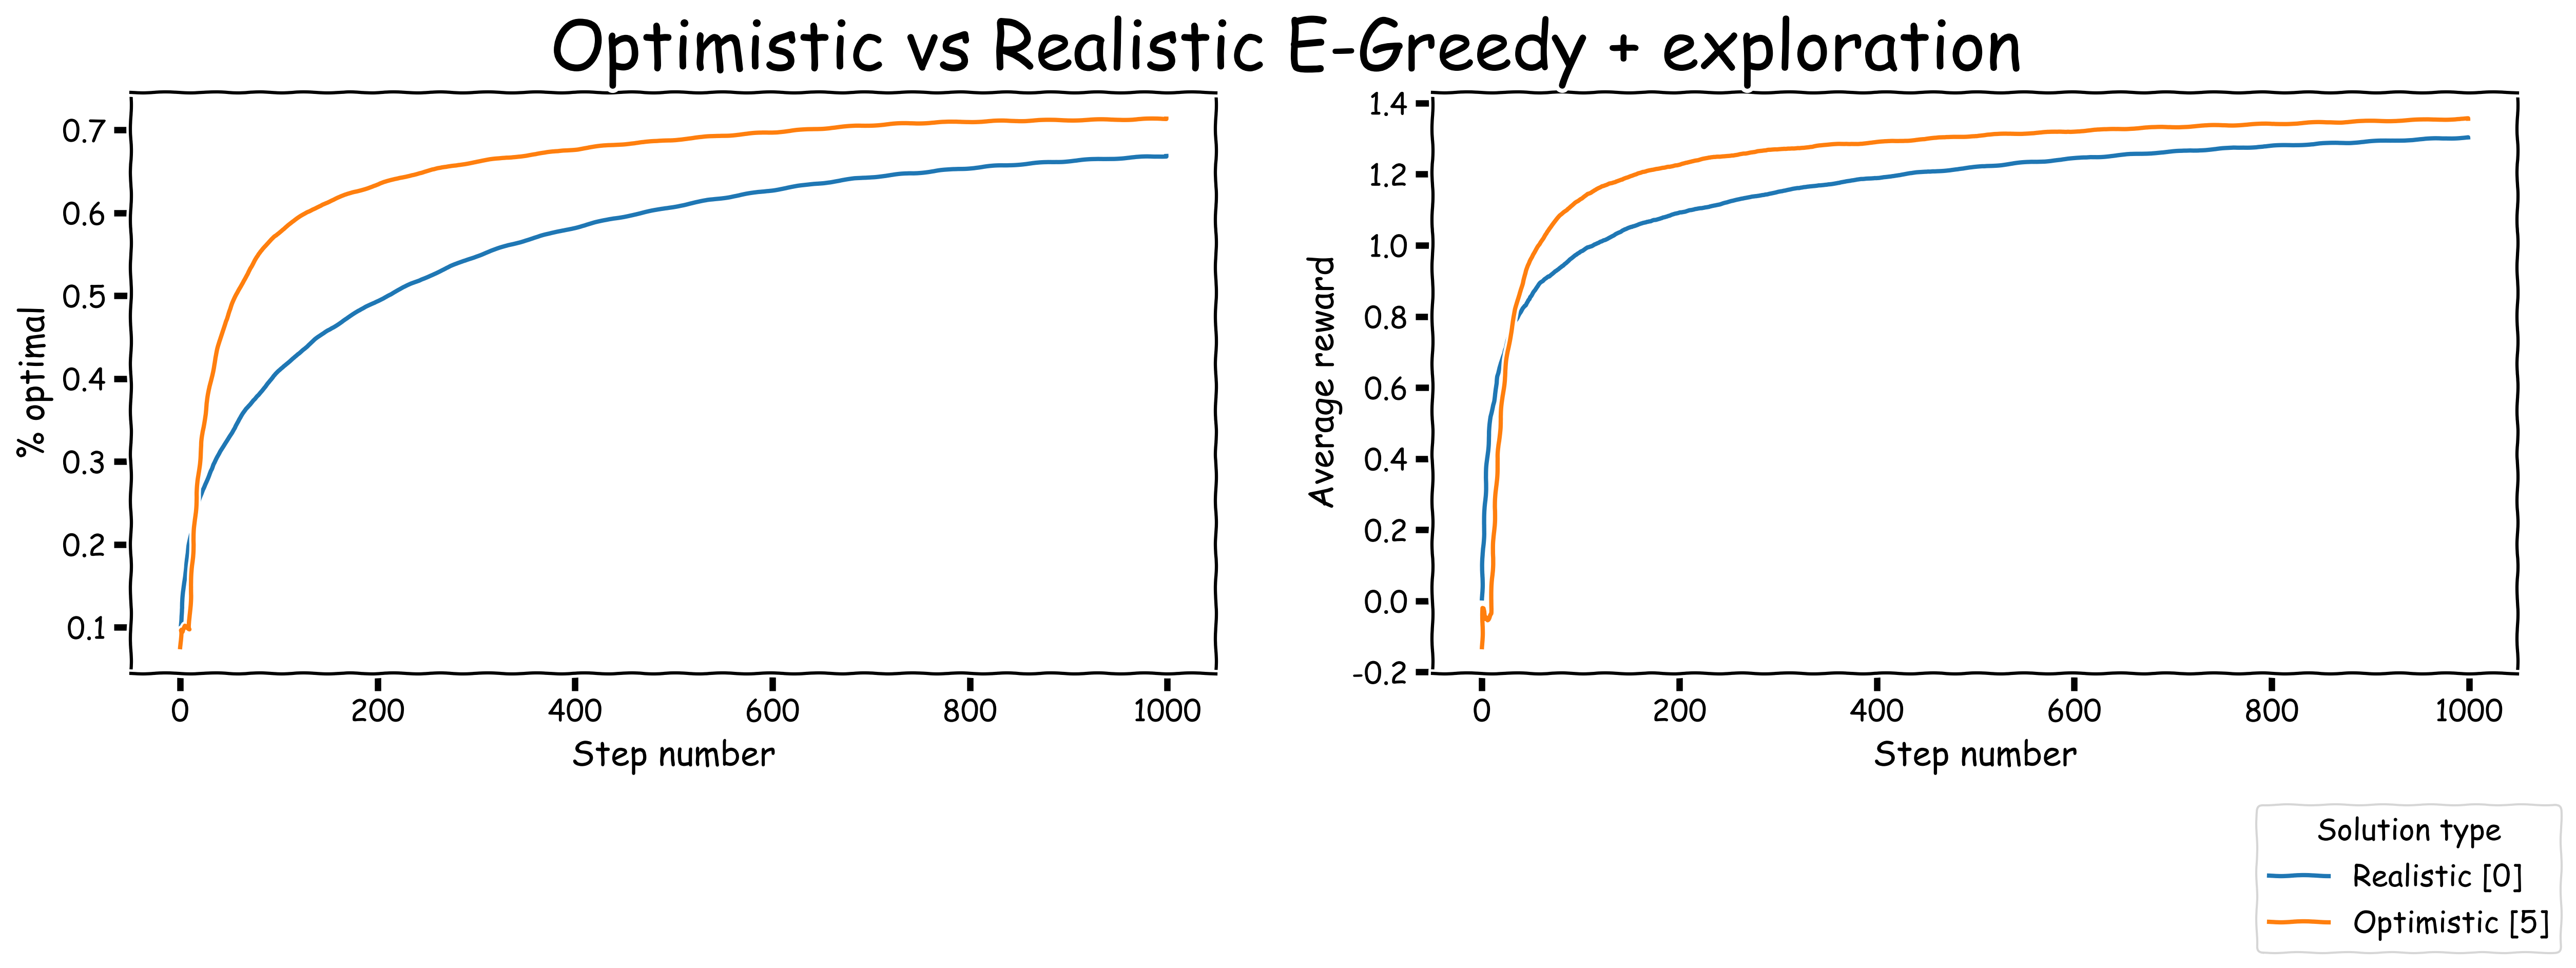

In [224]:
create_plots(exploration_data, 'Optimistic vs Realistic E-Greedy + exploration', 'Solution type')

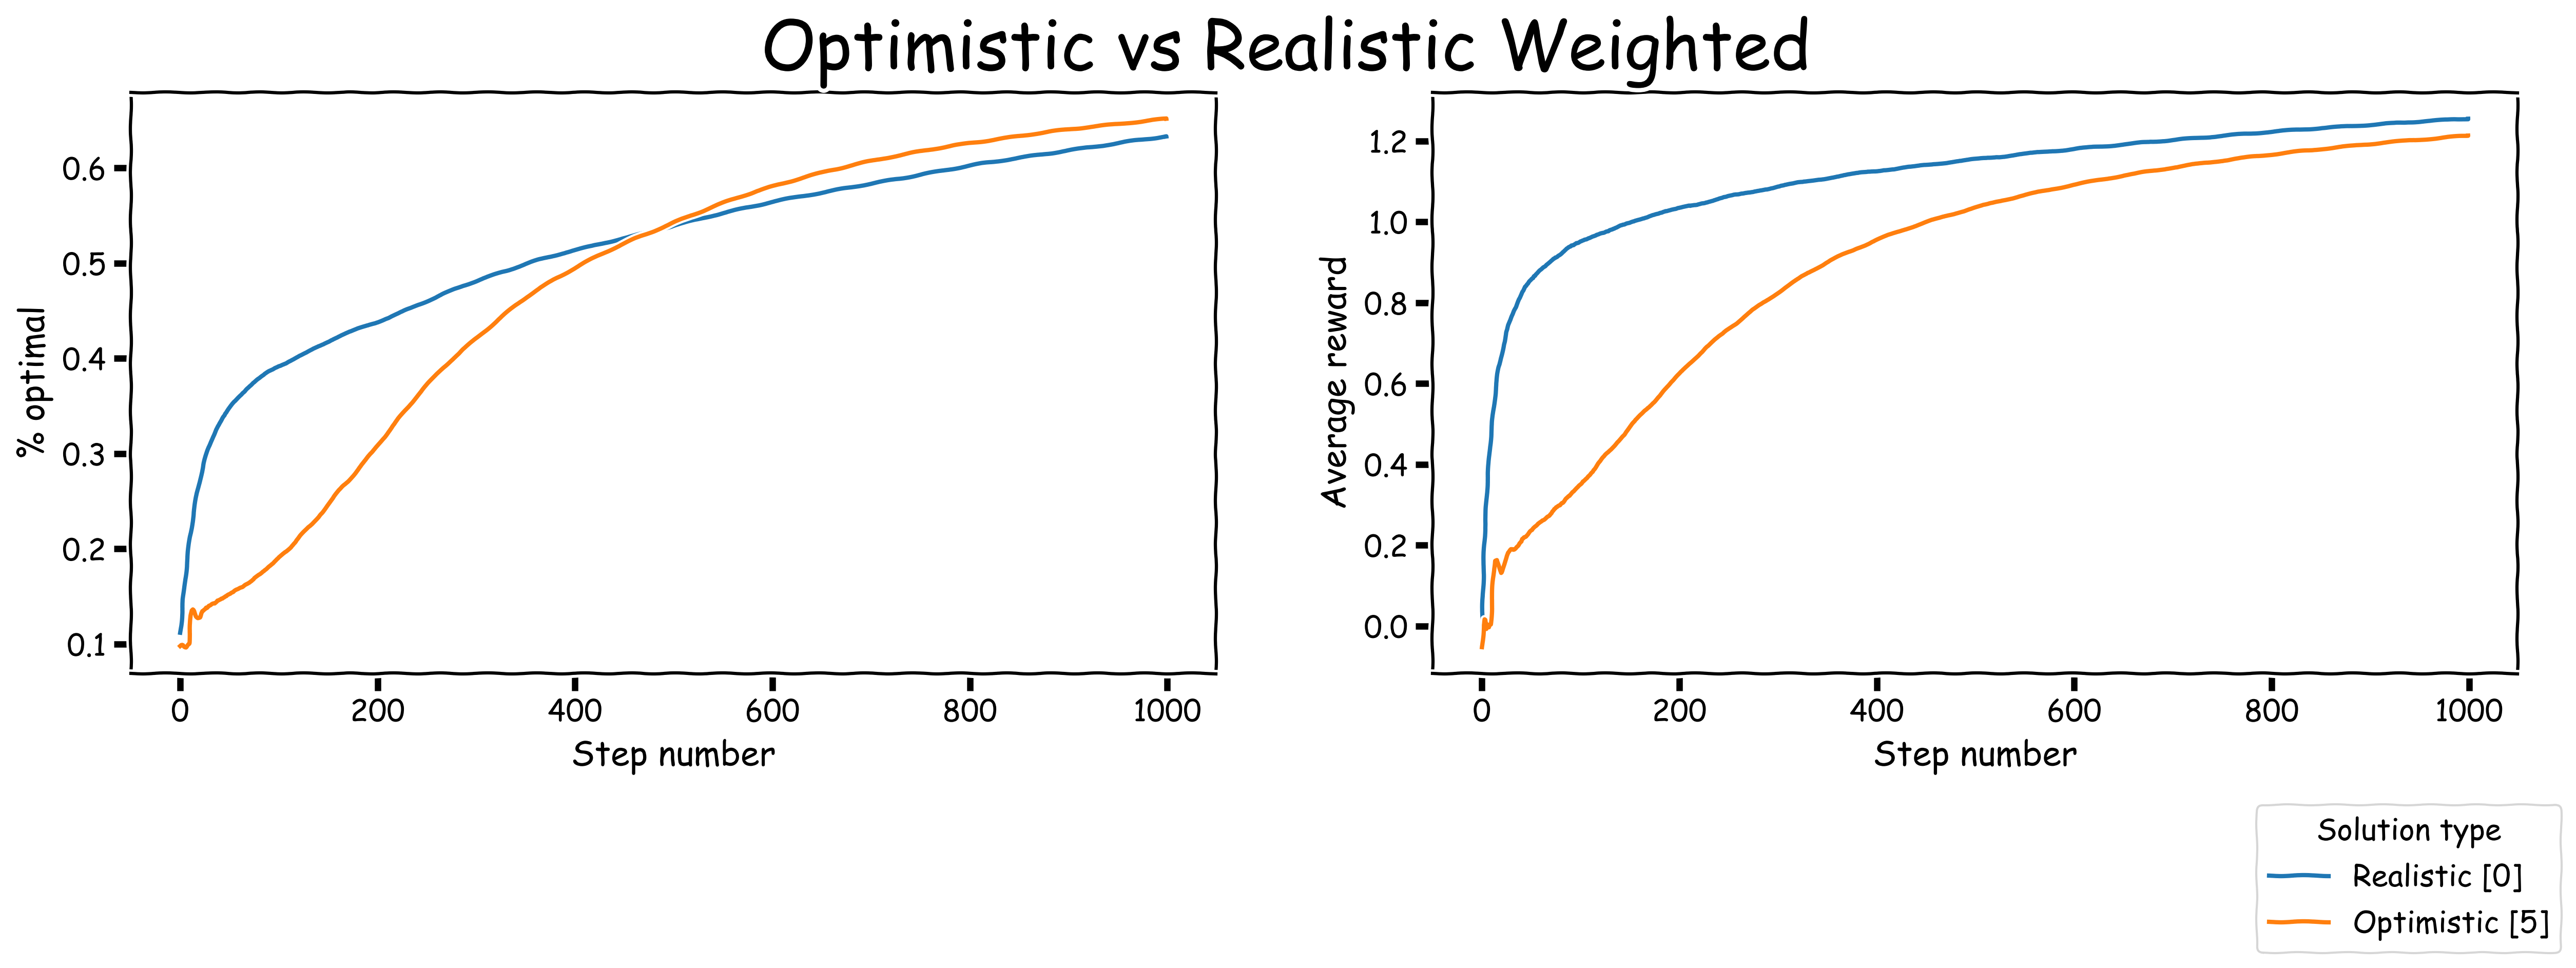

In [225]:
create_plots(weighted_data, 'Optimistic vs Realistic Weighted', 'Solution type')

# UCB solution

In [226]:
class UCB(KBanditSolution):
    
    def count_ucb(self, q, c, step, n):
        if n == 0:
            return sys.maxsize
        return (q + (c * sqrt((log(step) / n))))
    
    def solve(self, c):
        Q = {i: 0 for i in range(k)} # 1. Value function        
        N = {i: 0 for i in range(k)} # 2. Number of actions, for update rule

        for i in range(self.steps): # 3. Main loop
            Q_ucb = {i: self.count_ucb(Q[i], c, i + 1, N[i]) for i in range(k)} # 4. Count UCB
            action = max(Q_ucb, key=Q_ucb.get) # 5. Choose action with maximum UCB

            reward = self.problem.generate_reward(action) # 6. Get reward for current action
            N[action] += 1 # 7. Update action number
            Q[action] += (1 / N[action]) * (reward - Q[action]) # 8. Update value dict 
            self.count_statistics(action, reward, i)

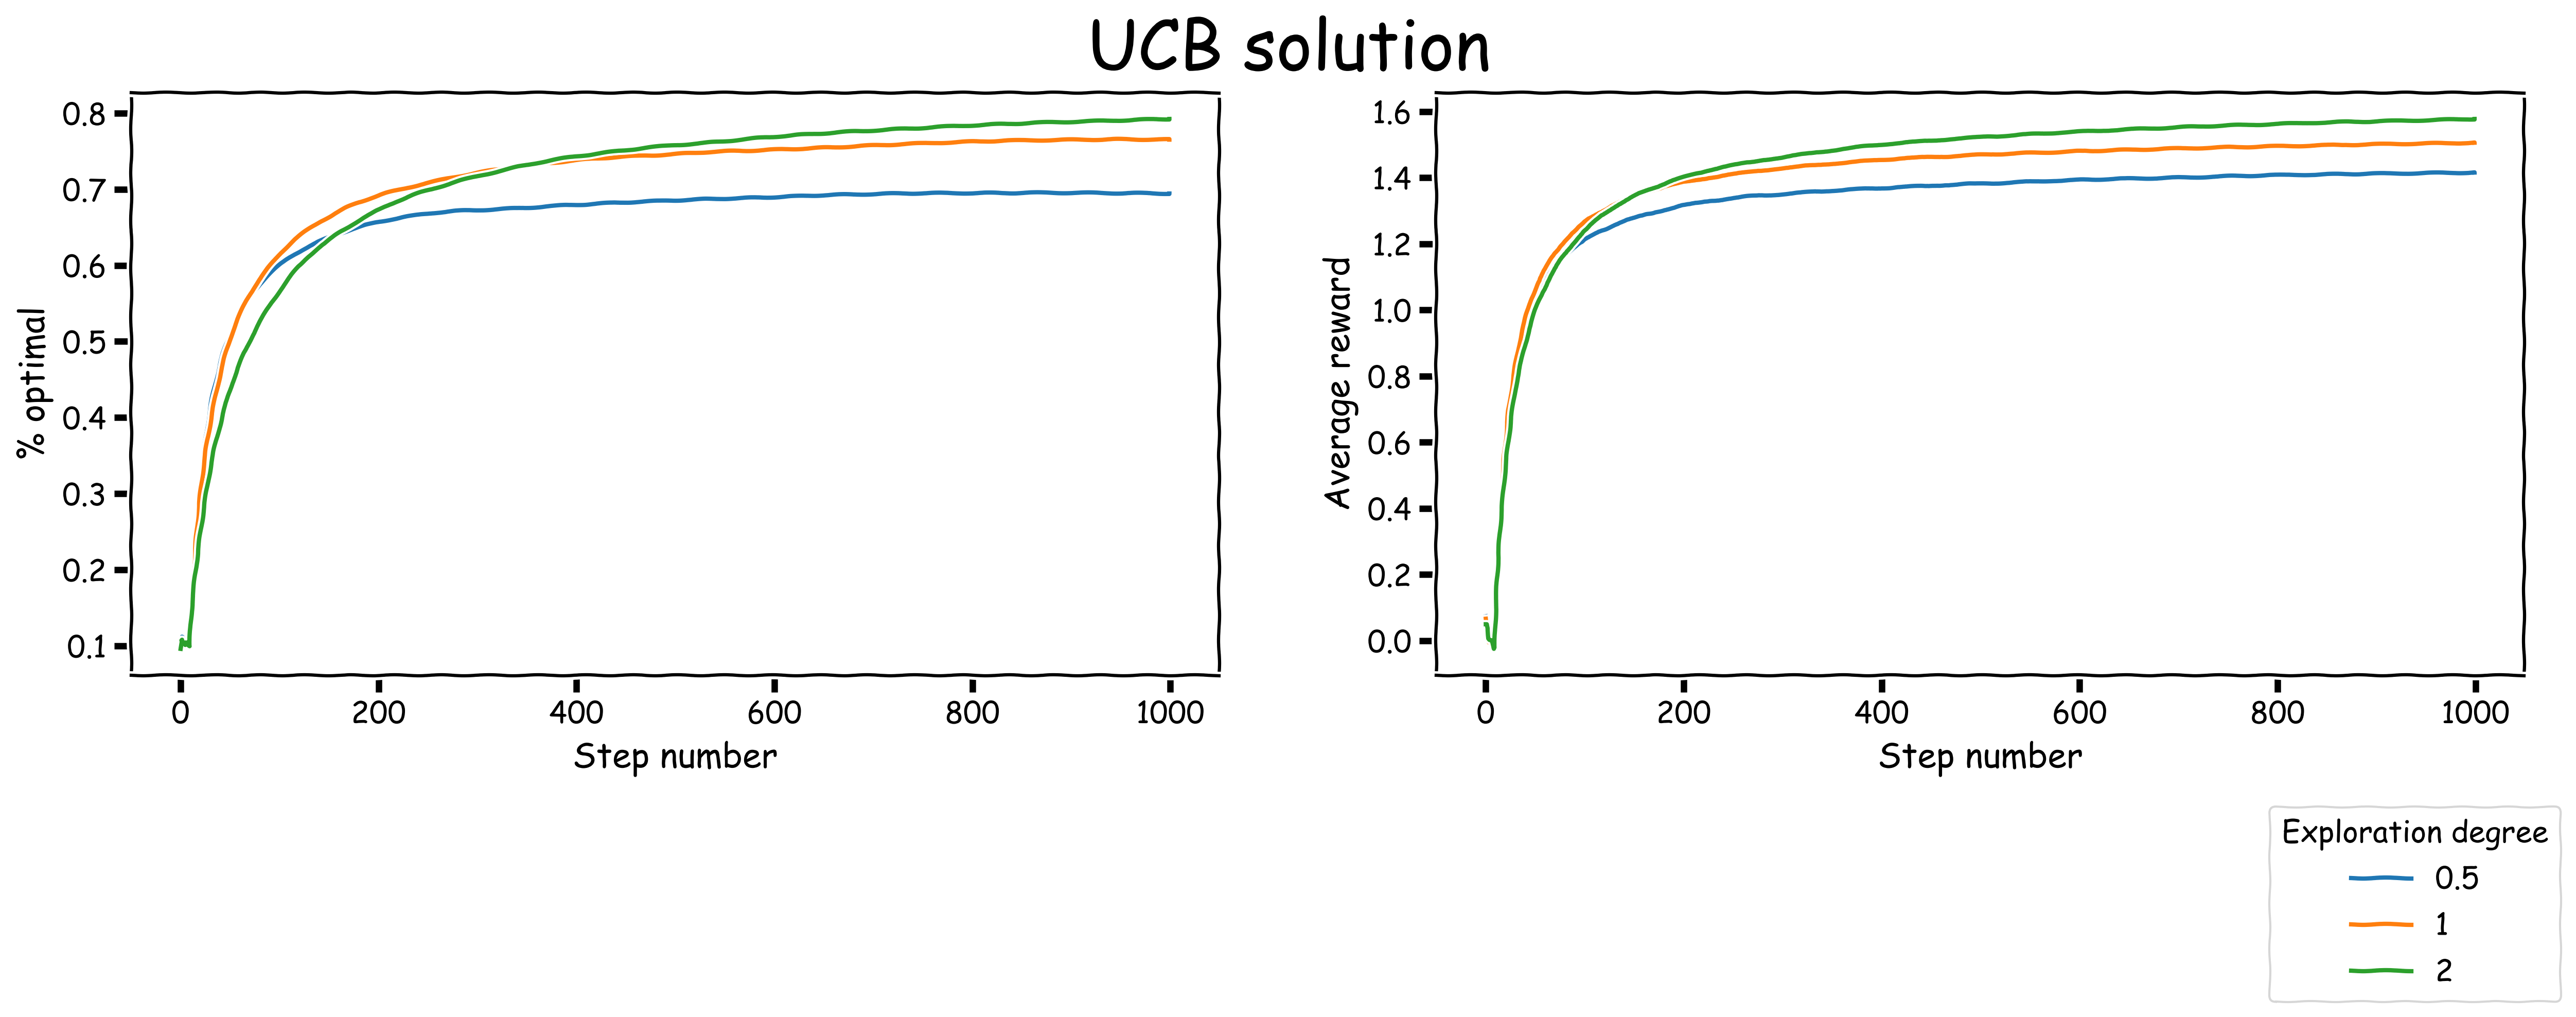

In [227]:
data = average_data(UCB, 'c', [0.5, 1, 2], steps=1000)
create_plots(data, 'UCB solution', 'Exploration degree', steps=1000)

# Summary

In [228]:
optimistic_E_greedy_data = average_data(EGreedy, 'exploration_rate', [0.0], {'initial_value': 5})
optimistic_exploration_data = average_data(EGreedy, 'exploration_rate', [0.1], {'initial_value': 5})
pessimistic_weighted_data = average_data(WeightedAverage, 'step_size', [0.1], solve_data={'exploration_rate': 0.1, 'initial_value': 0})
ucb_2 = average_data(UCB, 'c', [2])

In [229]:
data = {
    'Greedy Optimistic [5]': optimistic_E_greedy_data[0.0],
    'E-Greedy Optimistic [5]': optimistic_exploration_data[0.1],
    'Weighted Realistic [0]': pessimistic_weighted_data[0.1],
    'UCB': ucb_2[2]
}

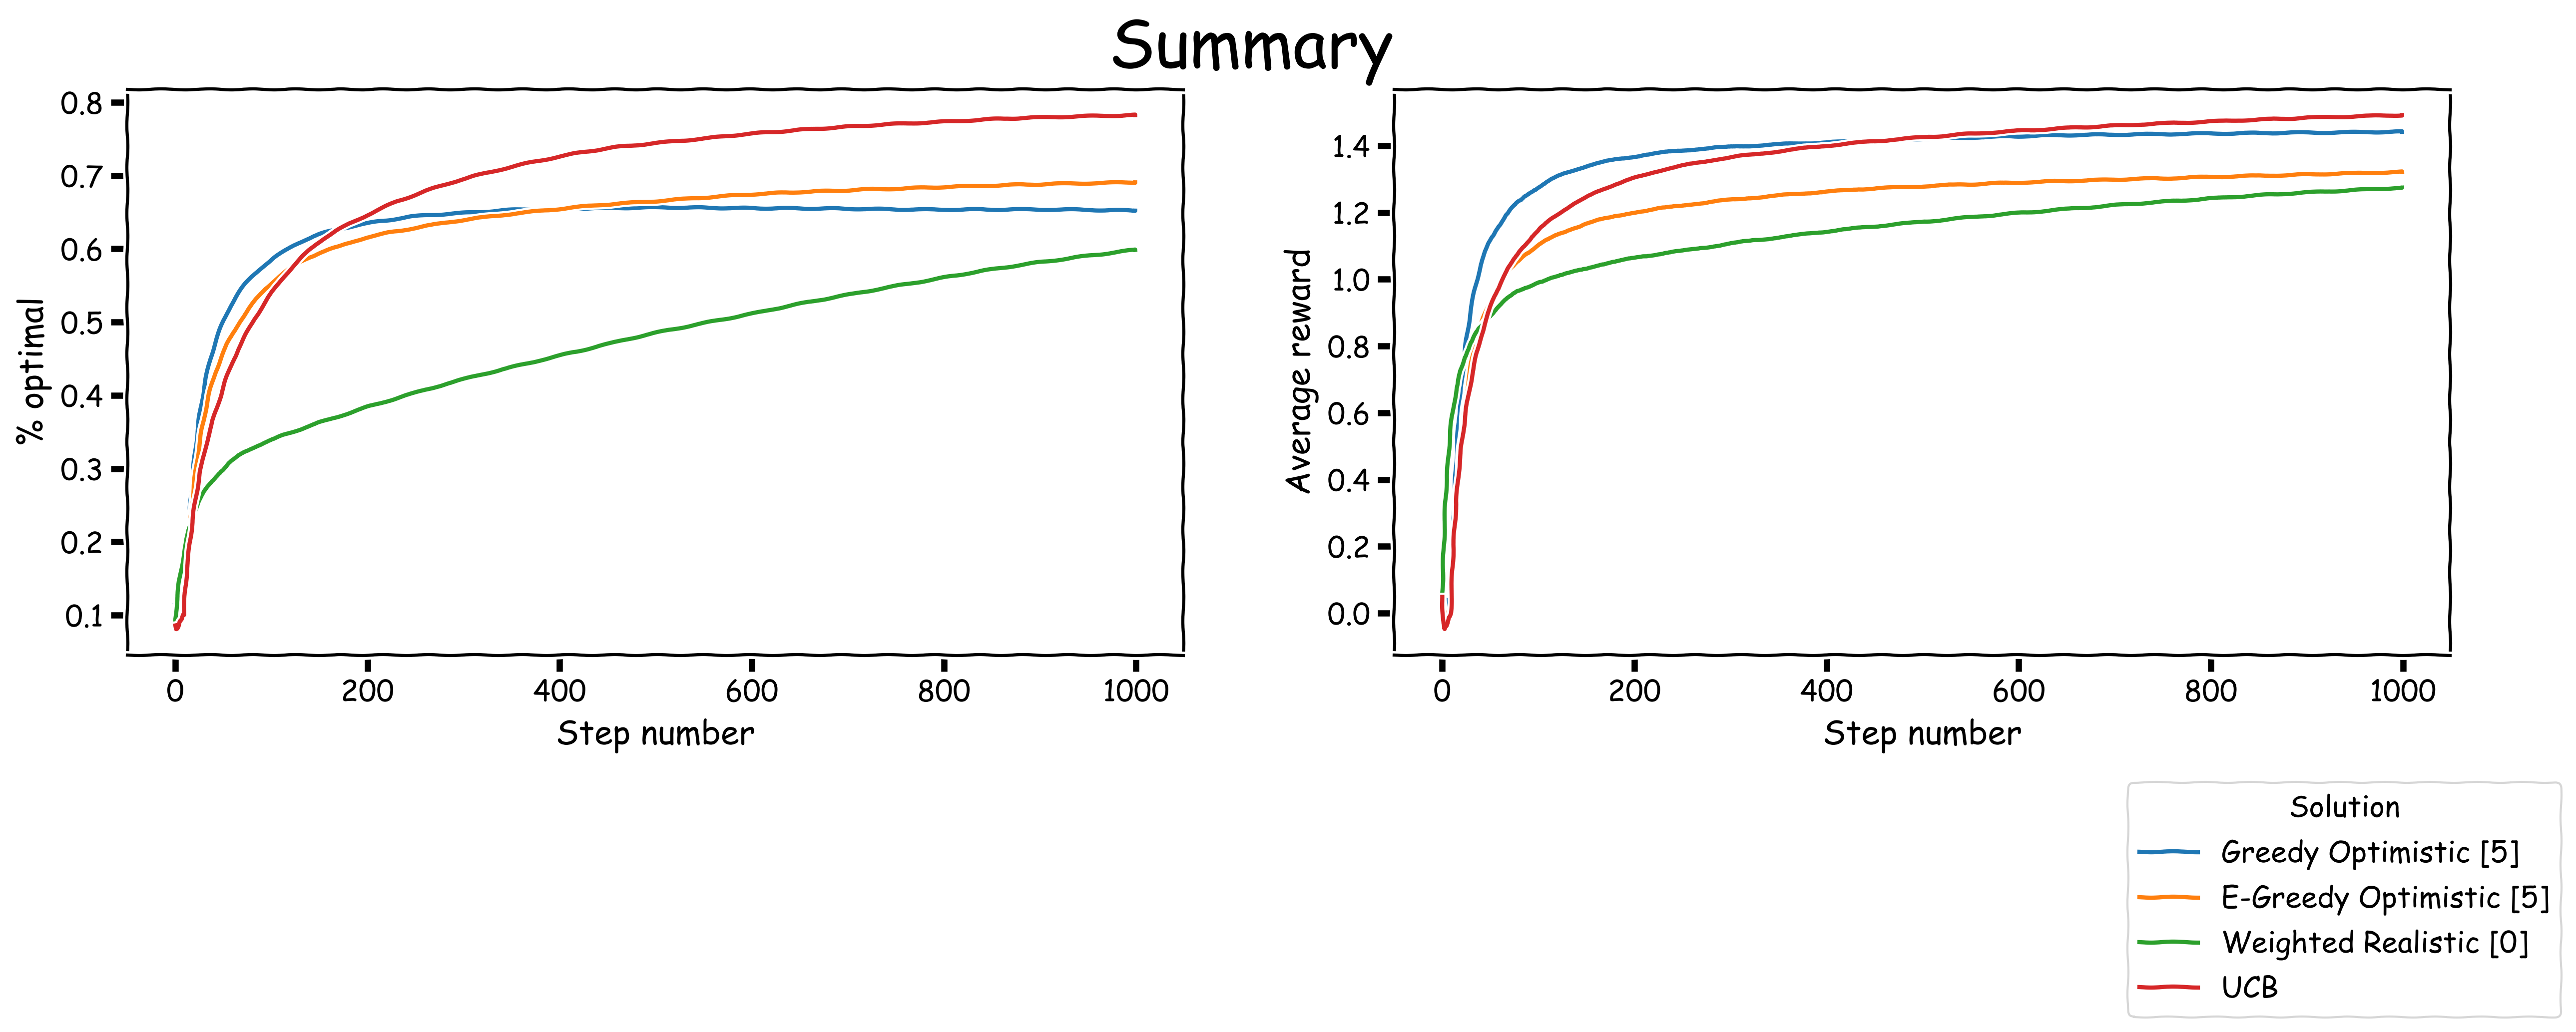

In [230]:
create_plots(data, 'Summary', 'Solution')